<a href="https://colab.research.google.com/github/idontcalculate/DogoApp/blob/main/dog_classification_2models_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

model deployment: EFFICIENTNETb0 + stanford dogs species dataset 100
+ztm style 3rd model same dataset 

arXiv paper: https://arxiv.org/pdf/1905.11946.pdf

keras documentation: https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

stanford dogs dataset:http://vision.stanford.edu/aditya86/ImageNetDogs/main.html

Number of categories: 120

Number of images: 20,580

In [1]:
import tensorflow as tf

In [ ]:
#TPU ACTIVATION 
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
   raise BaseException('ERROR: Not connected to a TPU runtime')
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [ ]:
import tensorflow_datasets as tfds

dataset, info = tfds.load(name="stanford_dogs", with_info=True)

In [ ]:
#visualize augmentation

for image, label in ds_train.take(2):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")
   

In [3]:
#importing dataset from tfds
import tensorflow_datasets as tfds

batch_size = 18

dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes
#tf.data.Dataset.from_tensor_slices()

In [4]:
#efficientnet expects images of size at least 200 x 200
IMG_SIZE =200
size = (IMG_SIZE, IMG_SIZE)

ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

In [5]:
# Create a data augmentation stage with horizontal flipping, rotations, zooms
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.layers import experimental 
from tensorflow.keras.layers.experimental import preprocessing

img_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  #preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="img_augmentation")

In [12]:
import matplotlib.pyplot as plt

In [7]:
#prefetch and autotune to improve performance
#one hot encoding 

def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)

implementing MobilNet


In [8]:
import tensorflow_datasets as tfds

dataset, info = tfds.load(name="stanford_dogs", with_info=True)

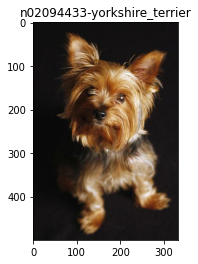

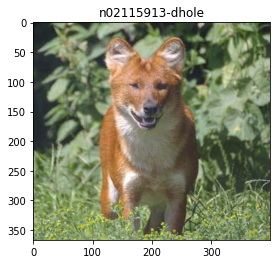

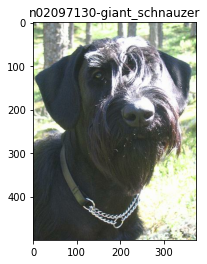

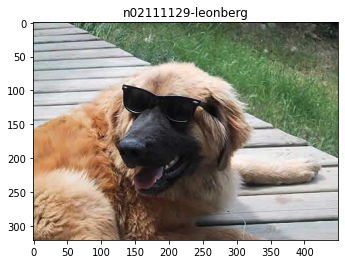

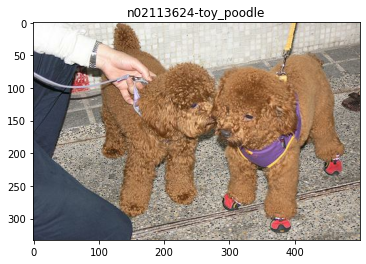

In [14]:
# function to convert label indices to breed names 
get_name = info.features['label'].int2str

for doggo in dataset['train'].take(5):
    plt.figure()
    plt.imshow(doggo['image'])
    plt.title(get_name(doggo['label']))

In [15]:
IMG_LEN = 224
IMG_SHAPE = (IMG_LEN,IMG_LEN,3)
N_BREEDS = 120

training_data = dataset['train']
test_data = dataset['test']

def preprocess(ds_row):
  
    # Image conversion int->float + resizing
    image = tf.image.convert_image_dtype(ds_row['image'], dtype=tf.float32)
    image = tf.image.resize(image, (IMG_LEN, IMG_LEN), method='nearest')
  
    # Onehot encoding labels
    label = tf.one_hot(ds_row['label'],N_BREEDS)

    return image, label

def prepare(dataset, batch_size=None):
    ds = dataset.map(preprocess, num_parallel_calls=4)
    ds = ds.shuffle(buffer_size=1000)
    if batch_size:
      ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [18]:
base_model.trainable = False

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(N_BREEDS, activation='softmax')
])

In [ ]:
# Didn't do any hyperparameter optimization
model.compile(optimizer=tf.keras.optimizers.Adamax(0.0023),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'top_k_categorical_accuracy'])
			  
train_batches = prepare(training_data, batch_size=32)
test_batches = prepare(test_data, batch_size=32)

history = model.fit(train_batches,
                    epochs=20,
                    validation_data=test_batches)

In [26]:
import numpy

['n02113023-pembroke', 'n02113186-cardigan', 'n02115641-dingo', 'n02099601-golden_retriever', 'n02105412-kelpie']


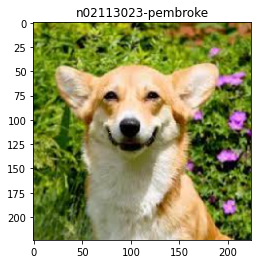

In [58]:
filename_dataset = tf.data.Dataset.list_files("/content/DOGO.PNG")
image_dataset = filename_dataset.map(lambda x: tf.io.decode_image(tf.io.read_file(x),channels=3))


for dog in image_dataset:

  class_names = {'image': dog, 'label': 0}
  pic, _ = preprocess(class_names)

  plt.figure()
  plt.imshow(pic)

  #img_tensor = tf.expand_dims(pic, axis=0)
  
  pred = model(img_tensor)
  top_components = tf.reshape(tf.math.top_k(pred, k=5).indices,shape=[-1])
  top_matches = [get_name(i) for i in top_components]

  plt.title(top_matches[0])
  print(top_matches)
  #print(img_tensor)